In [89]:
import sys #noqa
sys.path.append("../../") #noqa

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.special import rel_entr
import os
from python_src.compositions import multiplicative_aitchison, uniform_replace_zeroes
from python_src.figures_utils import get_all_expected, generate_experimental_df, get_relabund_files, fully_combined
from skbio.stats.composition import multiplicative_replacement
from scipy.spatial.distance import braycurtis, euclidean
from scipy.stats import pearsonr
from dataclasses import dataclass
from python_src.compositions import clr
from typing import Tuple, List
from utils.data_paths import make_data_list

In [90]:
def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

bmock12
/Users/valenciaem/coding/pipelines/expected_pipelines/bmock12
S1


,genus,RA,Source,SampleID
TAX_ID,,,,
2745,HALOMONAS,0.369208,Expected,S1
2742,MARINOBACTER,0.206265,Expected,S1
111500,MURICAUDA,0.180311,Expected,S1
497,PSYCHROBACTER,0.111128,Expected,S1
655352,COHAESIBACTER,0.070702,Expected,S1


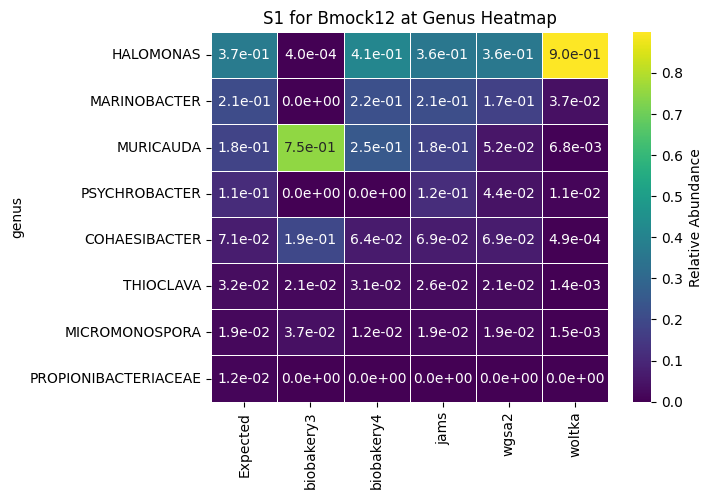

camisimGI
/Users/valenciaem/coding/pipelines/expected_pipelines/camisimGI
S1


,genus,RA,Source,SampleID
TAX_ID,,,,
517,BORDETELLA,0.561947,Expected,S1
1485,CLOSTRIDIUM,0.225664,Expected,S1
816,BACTEROIDES,0.097345,Expected,S1
909656,BACTEROIDES,0.026549,Expected,S1
1784836,FERMENTIMONAS,0.013274,Expected,S1


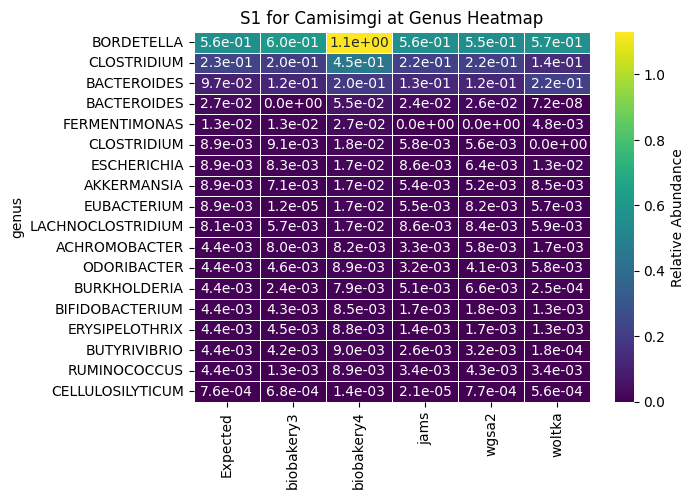

S2


,genus,RA,Source,SampleID
TAX_ID,,,,
517,BORDETELLA,0.366534,Expected,S2
1485,CLOSTRIDIUM,0.290837,Expected,S2
222,ACHROMOBACTER,0.147410,Expected,S2
841,ROSEBURIA,0.087649,Expected,S2
816,BACTEROIDES,0.061531,Expected,S2


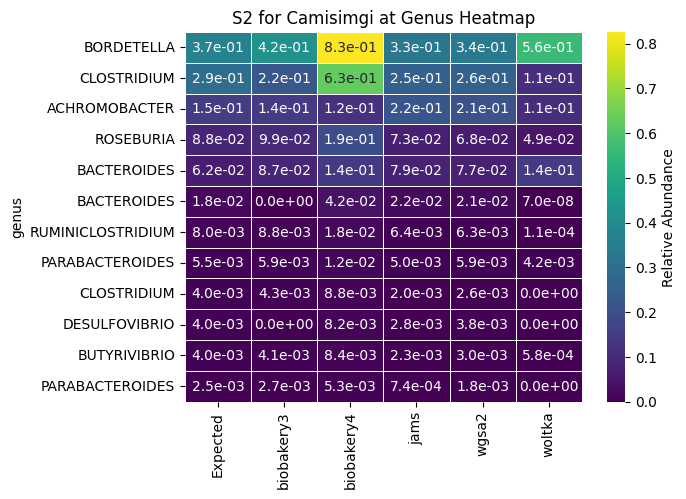

tourlousse
/Users/valenciaem/coding/pipelines/expected_pipelines/tourlousse
SRR17380241


,genus,RA,Source,SampleID
TAX_ID,,,,


ValueError: zero-size array to reduction operation fmin which has no identity

In [94]:
def heatmap(obs_root: str, exp_root: str, community: str, rank: str = "genus"):

    full_df = fully_combined(obs_root, exp_root, rank=rank)
    full_df.to_csv("full_df_nist.csv", index=False)
    exp_df = full_df[full_df["Source"] == "Expected"]
    obs_df = full_df[full_df["Source"] != "Expected"]

    for smpl, smpl_df in obs_df.groupby("SampleID"):
        print(smpl)
        # Have to choose where the expected data is also from the same sample. Might want to check figures.ipynb.
        exp_smpl_df = exp_df[exp_df["SampleID"] == smpl]

        display(exp_smpl_df.head())

        heatmap_df = pd.DataFrame()
        
        for src, src_df in smpl_df.groupby("Source"):
            # Join left on the index
            joined_df = exp_smpl_df.copy().join(src_df, how="left", lsuffix="_exp", rsuffix="_obs")

            # display(joined_df.head())

            # We need the format of feature on index and RA of each sample on columns.
            # Set genus_exp as index
            joined_df = joined_df.set_index(f"{rank}_exp")

            # We only need RA_obs columns.
            joined_df = joined_df[["RA_exp", "RA_obs"]]

            # Fill in missing values with 0
            joined_df = joined_df.fillna(0)

            rename_dict = {"RA_exp": "Expected", "RA_obs": src}
            joined_df = joined_df.rename(columns=rename_dict)

            heatmap_df = pd.concat([heatmap_df, joined_df], axis=1)
        
        # Drop duplicate columns since "Expected" is duplicated.
        heatmap_df = heatmap_df.loc[:, ~heatmap_df.columns.duplicated()]

        if rank == "genus":
            g = sns.heatmap(heatmap_df, cmap="viridis", cbar_kws={'label': 'Relative Abundance'}, annot=True, fmt=".1e", linewidths=0.5)
        else:
            g = sns.heatmap(heatmap_df, cmap="viridis", cbar_kws={'label': 'Relative Abundance'}, annot=False, linewidths=0.5)
        g.set(ylabel=rank)
        g.set_title(f"{smpl} for {community.capitalize()} at {rank.capitalize()} Heatmap")
        plt.show()

def make_heatmaps():
    dpaths = make_data_list()

    for p in dpaths:
        pipeline = p.path.split("/")[-1]
        if pipeline == "gut" or pipeline == "tongue":
            continue

        # Replace only the last occurence of the string "pipeline" with "expected"
        exp_root = rreplace(p.path, "pipeline", "expected_pipeline", 1)

        print(pipeline)
        print(exp_root)

        if not os.path.exists(exp_root):
            raise FileNotFoundError(f"Expected pipeline directory {exp_root} does not exist.")

        heatmap(p.path, exp_root, pipeline, rank="genus")

make_heatmaps()

# heatmap_one_to_one()
# heatmap_one_to_one("species")